In [1]:
#!/bin/bash
!kaggle datasets download sabahesaraki/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset
License(s): unknown
 97%|███████████████████████████████████████▉ | 190M/195M [00:01<00:00, 183MB/s]
100%|█████████████████████████████████████████| 195M/195M [00:01<00:00, 164MB/s]


In [ ]:
!unzip breast-ultrasound-images-dataset.zip

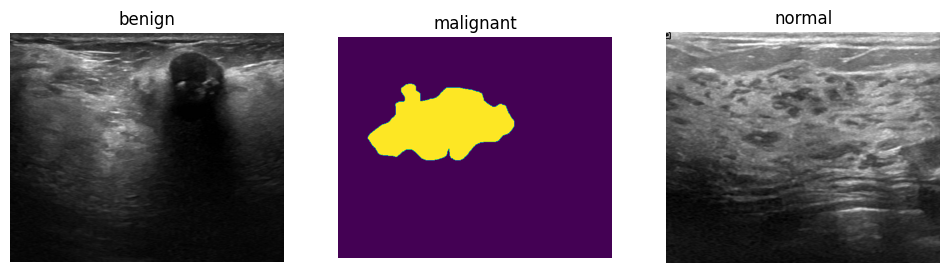

In [4]:
# show some sample images from the dataset
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define the directory where the images are stored
image_dir = '/kaggle/working/Dataset_BUSI_with_GT'

# Define the list of categories
categories = ['benign', 'malignant', 'normal']

# Function to display a random image from each category
def display_random_images(image_dir, categories, num_images=5):
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_dir = os.path.join(image_dir, category)
        image_files = os.listdir(category_dir)
        random_image = random.choice(image_files)
        img_path = os.path.join(category_dir, random_image)
        img = Image.open(img_path)
        img_array = np.array(img)
        plt.subplot(1, len(categories), i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Call the function to display random images
display_random_images(image_dir, categories)


In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [7]:
base_path = '/kaggle/working/Dataset_BUSI_with_GT'
categories = ['benign', 'malignant', 'normal']

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define image transformations (you can modify these as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.transforms.Normalize(
                    mean=[-m / s for m, s in zip(imagenet_mean, imagenet_std)],
                    std=[1 / s for s in imagenet_std]
                )
])


In [8]:
dataset = datasets.ImageFolder(root=base_path, transform=transform)


In [9]:
# Define train-test split ratio
train_ratio = 0.8
test_ratio = 0.2

# Calculate dataset sizes
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [10]:
batch_size = 32  # Adjust as per your resources

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# Check class indices
print(f"Class-to-index mapping: {dataset.class_to_idx}")

# Display a batch from train_loader
for images, labels in train_loader:
    print(f"Image batch dimensions: {images.shape}")
    print(f"Label batch dimensions: {labels.shape}")
    break


Class-to-index mapping: {'benign': 0, 'malignant': 1, 'normal': 2}
Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        # Load a pretrained ResNet18 model
        self.model = models.resnet18(pretrained=True)

        # Freeze the early layers if needed (optional, for transfer learning)
        for param in self.model.parameters():
            param.requires_grad = False  # Freeze all layers except the final fully connected layer

        # Modify the final fully connected layer for your 3-class problem
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 3)  # Replace fc layer for 3 output classes

    def forward(self, x):
        return self.model(x)


In [13]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

def model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=3):
    """
    Fine-tune a model with early stopping and learning rate scheduler.

    Args:
        model: The PyTorch model to be fine-tuned.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer for training.
        num_epochs: Number of fine-tuning epochs.
        device: Training device (CPU or GPU).
        patience: Number of epochs with no improvement before stopping.
    """
    model.to(device)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    best_loss = float('inf')  # Initialize best validation loss
    best_model_weights = None
    no_improvement_epochs = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        # Average validation loss
        val_loss /= len(val_loader)

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Print training progress
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss:.4f}, Accuracy: {correct/total:.4f}")

        # Check for improvement
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()  # Save the best model weights
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        # Early stopping condition
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Load the best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    return model


In [14]:

model = TransferLearningModel()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


best_model = model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    device=device,
    patience=5
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Epoch 1/20, Train Loss: 0.8276, Val Loss: 0.7631, Accuracy: 0.6551
Epoch 2/20, Train Loss: 0.5701, Val Loss: 0.6204, Accuracy: 0.7563
Epoch 3/20, Train Loss: 0.5112, Val Loss: 0.4897, Accuracy: 0.8133
Epoch 4/20, Train Loss: 0.4520, Val Loss: 0.4578, Accuracy: 0.8165
Epoch 5/20, Train Loss: 0.4088, Val Loss: 0.4471, Accuracy: 0.8070
Epoch 6/20, Train Loss: 0.3848, Val Loss: 0.4277, Accuracy: 0.8259
Epoch 7/20, Train Loss: 0.3877, Val Loss: 0.4164, Accuracy: 0.8418
Epoch 8/20, Train Loss: 0.3695, Val Loss: 0.4109, Accuracy: 0.8354
Epoch 9/20, Train Loss: 0.3555, Val Loss: 0.4092, Accuracy: 0.8449
Epoch 10/20, Train Loss: 0.3341, Val Loss: 0.4064, Accuracy: 0.8418
Epoch 11/20, Train Loss: 0.3421, Val Loss: 0.3990, Accuracy: 0.8386
Epoch 12/20, Train Loss: 0.3279, Val Loss: 0.3860, Accuracy: 0.8354
Epoch 13/20, Train Loss: 0.3290, Val Loss: 0.3811, Accuracy: 0.8418
Epoch 14/20, Train Loss: 0.3091, Val Loss: 0.3983, Accuracy: 0.8544
Epoch 15/20, Train Loss: 0.3042, Val Loss: 0.4004, Accura

In [15]:
class BreastCancerClassifier(nn.Module):
    def __init__(self, input_channels=3, num_classes=3):
        super(BreastCancerClassifier, self).__init__()
        # Convolutional Layers with BatchNorm and Dropout
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully Connected Layers
        self.fc1 = nn.Linear(100352, 512)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [16]:
model_nn = TransferLearningModel()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


best_model_nn = model_with_early_stopping(
    model=model_nn,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    device=device,
    patience=5
)

Epoch 1/20, Train Loss: 0.7793, Val Loss: 0.7349, Accuracy: 0.7310
Epoch 2/20, Train Loss: 0.5284, Val Loss: 0.5404, Accuracy: 0.7880
Epoch 3/20, Train Loss: 0.4771, Val Loss: 0.4918, Accuracy: 0.7943
Epoch 4/20, Train Loss: 0.4167, Val Loss: 0.4521, Accuracy: 0.8228
Epoch 5/20, Train Loss: 0.3979, Val Loss: 0.4314, Accuracy: 0.8386
Epoch 6/20, Train Loss: 0.3828, Val Loss: 0.4372, Accuracy: 0.8386
Epoch 7/20, Train Loss: 0.3656, Val Loss: 0.4088, Accuracy: 0.8576
Epoch 8/20, Train Loss: 0.3605, Val Loss: 0.4041, Accuracy: 0.8481
Epoch 9/20, Train Loss: 0.3663, Val Loss: 0.4023, Accuracy: 0.8513
Epoch 10/20, Train Loss: 0.3245, Val Loss: 0.4006, Accuracy: 0.8386
Epoch 11/20, Train Loss: 0.3325, Val Loss: 0.3910, Accuracy: 0.8449
Epoch 12/20, Train Loss: 0.3304, Val Loss: 0.4177, Accuracy: 0.8481
Epoch 13/20, Train Loss: 0.3169, Val Loss: 0.3847, Accuracy: 0.8481
Epoch 14/20, Train Loss: 0.2926, Val Loss: 0.3752, Accuracy: 0.8544
Epoch 15/20, Train Loss: 0.2953, Val Loss: 0.3732, Accura

In [17]:
from torchsummary import summary
summary(best_model, (3, 224, 224))
summary(best_model_nn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

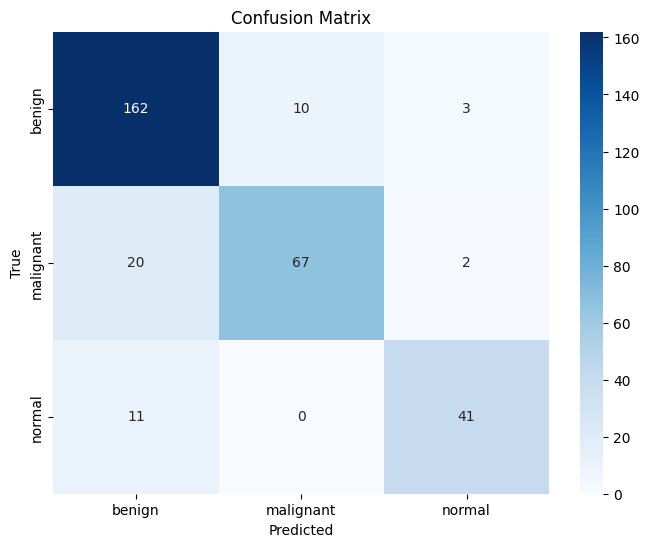

              precision    recall  f1-score   support

      benign       0.84      0.93      0.88       175
   malignant       0.87      0.75      0.81        89
      normal       0.89      0.79      0.84        52

    accuracy                           0.85       316
   macro avg       0.87      0.82      0.84       316
weighted avg       0.86      0.85      0.85       316



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()
    print(classification_report(y_true, y_pred, target_names=labels))



def evaluate(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return y_true, y_pred,


y_true, y_pred, accuracy = evaluate(best_model, test_loader)

labels = dataset.classes
plot_confusion_matrix(y_true, y_pred, labels)

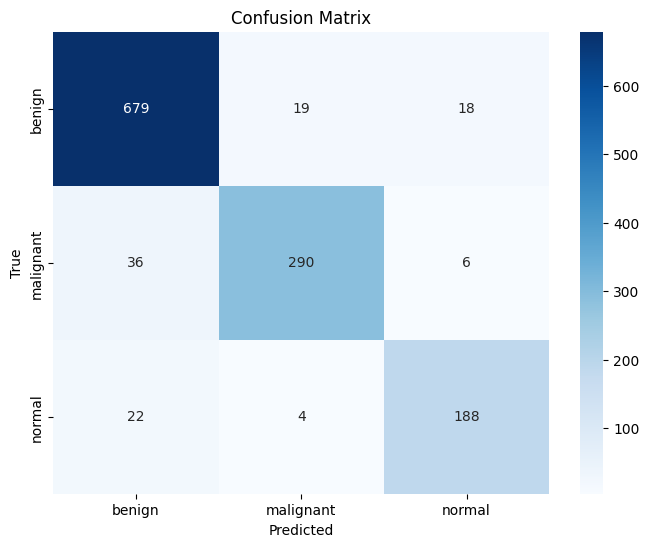

              precision    recall  f1-score   support

      benign       0.92      0.95      0.93       716
   malignant       0.93      0.87      0.90       332
      normal       0.89      0.88      0.88       214

    accuracy                           0.92      1262
   macro avg       0.91      0.90      0.91      1262
weighted avg       0.92      0.92      0.92      1262



In [24]:
y_true, y_pred, train_accuracy = evaluate(best_model, train_loader)

labels = dataset.classes
plot_confusion_matrix(y_true, y_pred, labels)

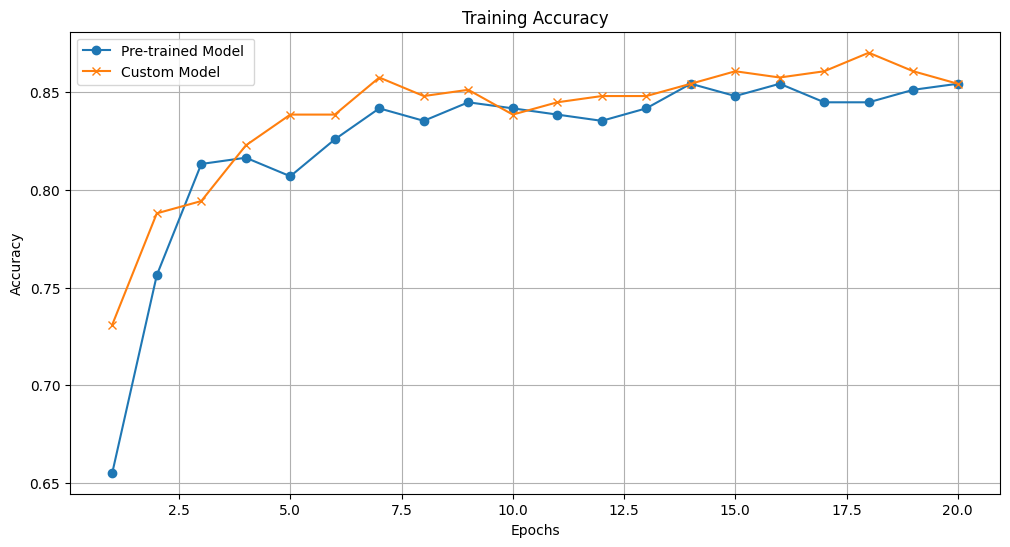

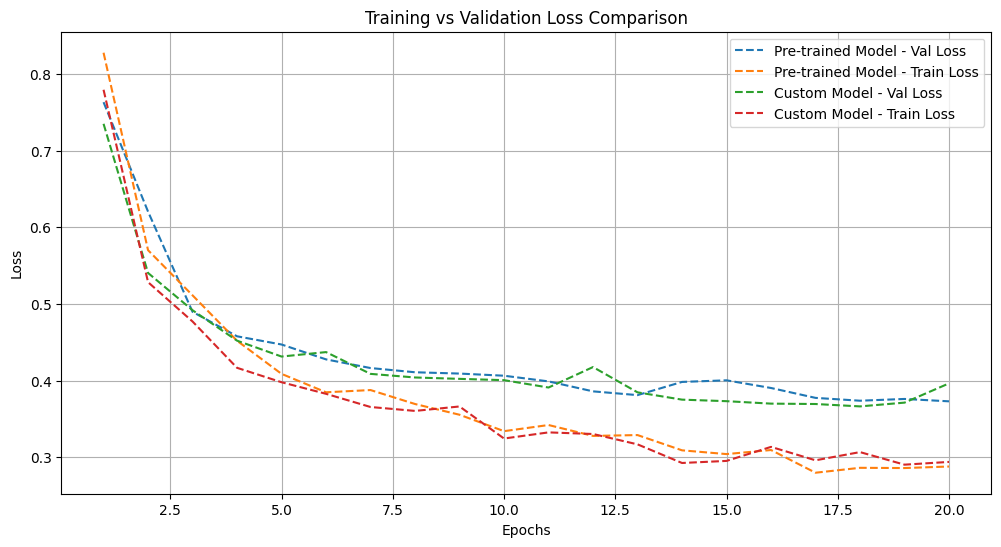

In [50]:
import matplotlib.pyplot as plt

# Accuracy and Loss data for Pre-trained model (model 1)
accuracy_pretrained = [
    0.6551, 0.7563, 0.8133, 0.8165, 0.8070, 0.8259, 0.8418, 0.8354, 0.8449, 0.8418,
    0.8386, 0.8354, 0.8418, 0.8544, 0.8481, 0.8544, 0.8449, 0.8449, 0.8513, 0.8544
]

val_loss_pretrained = [
    0.7631, 0.6204, 0.4897, 0.4578, 0.4471, 0.4277, 0.4164, 0.4109, 0.4092, 0.4064,
    0.3990, 0.3860, 0.3811, 0.3983, 0.4004, 0.3904, 0.3775, 0.3738, 0.3761, 0.3730
]
train_loss_pretrained = [
    0.8276, 0.5701, 0.5112, 0.4520, 0.4088, 0.3848, 0.3877, 0.3695, 0.3555, 0.3341,
    0.3421, 0.3279, 0.3290, 0.3091, 0.3042, 0.3095, 0.2799, 0.2863, 0.2860, 0.2880
]

# Accuracy and Loss data for Custom model (model 2)
accuracy_custom = [
    0.7310, 0.7880, 0.7943, 0.8228, 0.8386, 0.8386, 0.8576, 0.8481, 0.8513, 0.8386,
    0.8449, 0.8481, 0.8481, 0.8544, 0.8608, 0.8576, 0.8608, 0.8703, 0.8608, 0.8544
]


val_loss_custom = [
    0.7349, 0.5404, 0.4918, 0.4521, 0.4314, 0.4372, 0.4088, 0.4041, 0.4023, 0.4006,
    0.3910, 0.4177, 0.3847, 0.3752, 0.3732, 0.3700, 0.3695, 0.3664, 0.3713, 0.3964
]
train_loss_custom = [
    0.7793, 0.5284, 0.4771, 0.4167, 0.3979, 0.3828, 0.3656, 0.3605, 0.3663, 0.3245,
    0.3325, 0.3304, 0.3169, 0.2926, 0.2953, 0.3136, 0.2961, 0.3068, 0.2904, 0.2940
]

# Plotting Accuracy Comparison
plt.figure(figsize=(12, 6))

# Plotting accuracy for Pre-trained model
plt.plot(range(1, 21), accuracy_pretrained, label='Pre-trained Model ', marker='o')
plt.plot(range(1, 21), accuracy_custom, label='Custom Model ', marker='x')

# Adding labels and title for accuracy plot
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show Accuracy Plot
plt.show()

# Plotting Loss Comparison
plt.figure(figsize=(12, 6))

# Plotting loss for Pre-trained model
plt.plot(range(1, 21), val_loss_pretrained, label='Pre-trained Model - Val Loss', linestyle='--')
plt.plot(range(1, 21), train_loss_pretrained, label='Pre-trained Model - Train Loss', linestyle='--')

# Plotting loss for Custom model
plt.plot(range(1, 21), val_loss_custom, label='Custom Model - Val Loss', linestyle='--')
plt.plot(range(1, 21), train_loss_custom, label='Custom Model - Train Loss', linestyle='--')

# Adding labels and title for loss plot
plt.title('Training vs Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show Loss Plot
plt.show()


Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : benign


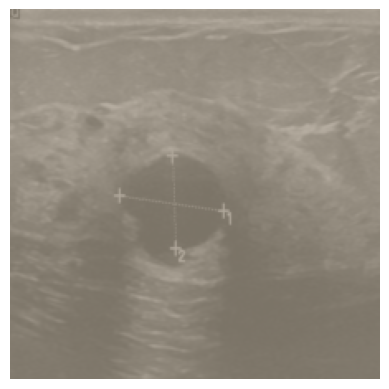

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : benign


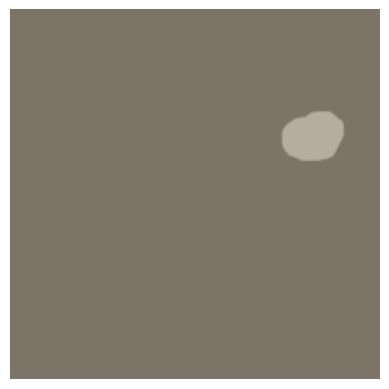

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : benign


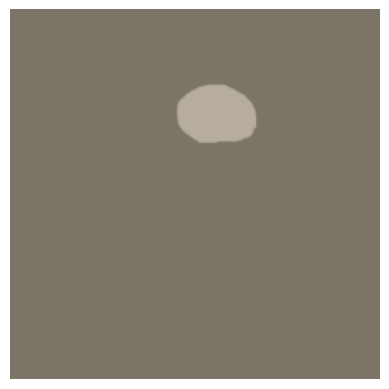

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : benign


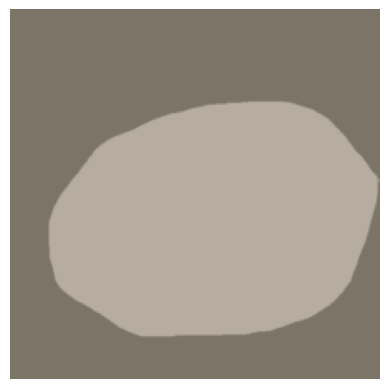

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : normal


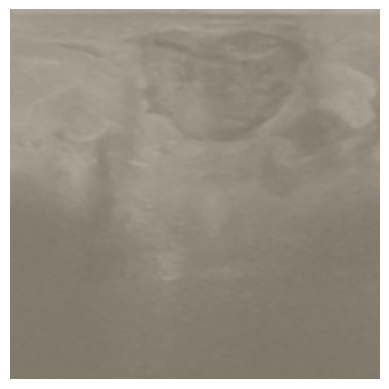

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : benign


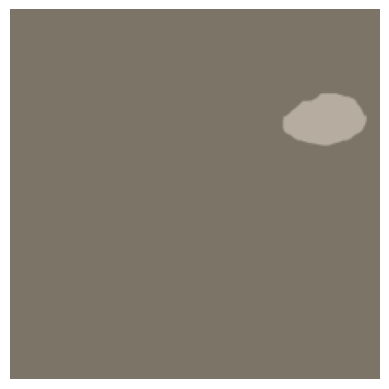

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : benign


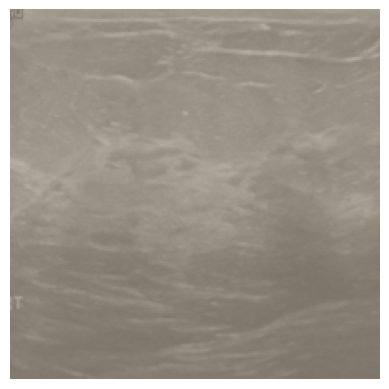

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : benign


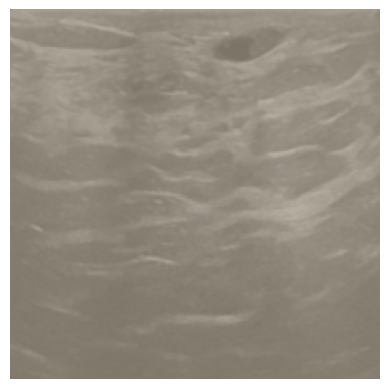

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Predicted class for image : malignant


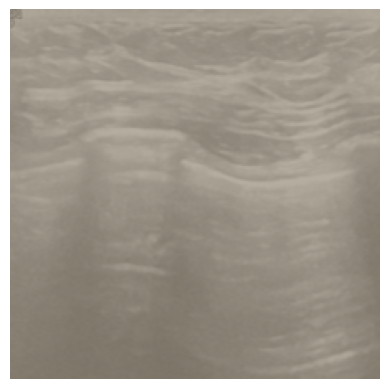

Image batch dimensions: torch.Size([28, 3, 224, 224])
Label batch dimensions: torch.Size([28])
Predicted class for image : benign


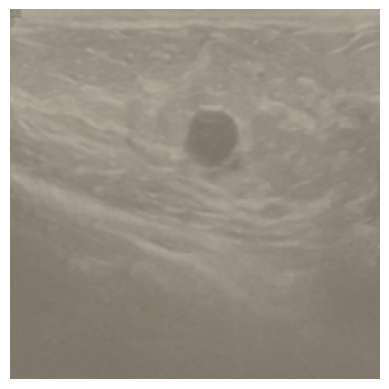

In [72]:
import torch
import matplotlib.pyplot as plt

# Assuming the model is already defined and test_loader is available
model.eval().to(device)  # Set model to evaluation mode and move to device

for images, labels in test_loader:
    # Print the dimensions of images and labels
    print(f"Image batch dimensions: {images.shape}")
    print(f"Label batch dimensions: {labels.shape}")

    with torch.no_grad():  # Disable gradient calculation during inference
        inputs, labels = images.to(device), labels.to(device)
        output = model(inputs)  # Forward pass
        _, predicted = torch.max(output, 1)  # Get the predicted class

        # Print predicted classes for each image in the batch
        for i in range(predicted.size(0)):
            print(f'Predicted class for image : {dataset.classes[predicted[i].item()]}')

            # Plot the first image in the batch
            plt.imshow(images[5].squeeze().permute(1, 2, 0).cpu())  # Plot only the first image in the batch
            plt.axis('off')  # Turn off axis
            plt.show()
            break  # Only process and plot the first batch
